## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [197]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "sgt",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [199]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [200]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 


,Satz,Tokens,Klassierung,Bemerkungen,label
0,Leitthema Trauma Berufskrankh 2016 · 18:275–28...,"['leitthema', 'trauma', 'berufskrankh', '2016'...",REFERENCE,NaN,low
1,"für Wirbelsäulenchirurgie, Berufsgenossenschaf...","['für', 'wirbelsäulenchirurgie', 'berufsgenoss...",TITLE,NaN,low
2,83 mischten lympho-epithelialen ~eubildungen d...,"['83', 'mischten', 'lympho-epithelialen', 'eub...",LOW_QUALITY,NaN,low
3,iVikolaus G. Chlopin.,"['ivikolaus', 'g', 'chlopin']",REFERENCE,NaN,low
4,Langenbecks Archivf.rChirurgie Langenbecks Ar...,"['langenbecks', 'archivfrchirurgie', 'langenbe...",REFERENCE,NaN,low


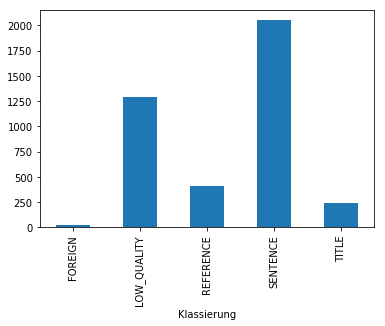

In [201]:
data.groupby('Klassierung').Klassierung.count().plot.bar()


data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
# data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()

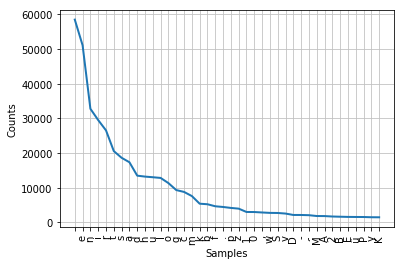

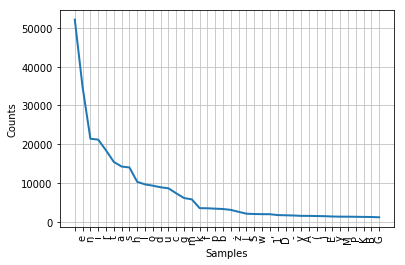

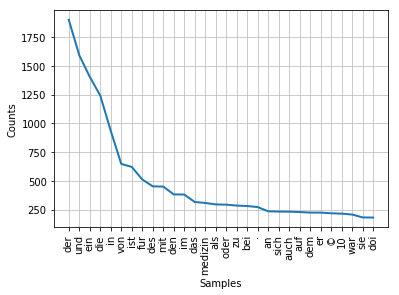

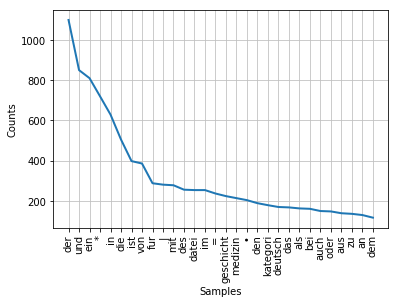

In [202]:
# character frequency analysis

high_quality = data.loc[data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]]

fdc = nltk.FreqDist()
tokens_h = []
for s in high_quality['Satz']:
    tokens_h.extend(tokenizer.tokenize(s))
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

tokens_l = []
fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    tokens_l.extend(tokenizer.tokenize(s))
    fdc2.update(s)
    fdc.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)

# word frequencies
fd = nltk.FreqDist(tokens_h)
fd.plot(30,cumulative=False) 
fd = nltk.FreqDist(tokens_l)
fd.plot(30,cumulative=False) 

In [209]:
# set input data
import numpy as np

fd = nltk.FreqDist(tokens_h + tokens_l)

voc = list(fd.keys())[:2000]

def convert_sentence_to_input(s):
    fd = nltk.FreqDist(tokenizer.tokenize(s))
    return np.array([fd.freq(c) for c in voc], dtype=np.float32)

data['input'] = pd.Series([[convert_sentence_to_input(s)] for s in data['Satz']], index=data.index)
data.head()

,Satz,Tokens,Klassierung,Bemerkungen,label,input
0,Leitthema Trauma Berufskrankh 2016 · 18:275–28...,"['leitthema', 'trauma', 'berufskrankh', '2016'...",REFERENCE,NaN,low,"[[0.030303, 0.030303, 0.030303, 0.0909091, 0.1..."
1,"für Wirbelsäulenchirurgie, Berufsgenossenschaf...","['für', 'wirbelsäulenchirurgie', 'berufsgenoss...",TITLE,NaN,low,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,83 mischten lympho-epithelialen ~eubildungen d...,"['83', 'mischten', 'lympho-epithelialen', 'eub...",LOW_QUALITY,NaN,low,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,iVikolaus G. Chlopin.,"['ivikolaus', 'g', 'chlopin']",REFERENCE,NaN,low,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Langenbecks Archivf.rChirurgie Langenbecks Ar...,"['langenbecks', 'archivfrchirurgie', 'langenbe...",REFERENCE,NaN,low,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
# fit a model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='linear', gamma=2),
    # SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf', gamma=2),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 5, 2), random_state=1)
]

X_train, X_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), data['label'], random_state = 0)

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [model.fit(X_train, y_train) for model in models]


Recognition rate for <class 'sklearn.ensemble.forest.RandomForestClassifier'>: 0.724275724276
Recognition rate for <class 'sklearn.svm.classes.LinearSVC'>: 0.799200799201
Recognition rate for <class 'sklearn.naive_bayes.MultinomialNB'>: 0.672327672328
Recognition rate for <class 'sklearn.linear_model.logistic.LogisticRegression'>: 0.758241758242
Recognition rate for <class 'sklearn.svm.classes.SVC'>: 0.762237762238
Recognition rate for <class 'sklearn.svm.classes.SVC'>: 0.487512487512
Recognition rate for <class 'sklearn.svm.classes.SVC'>: 0.786213786214
Recognition rate for <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>: 0.798201798202


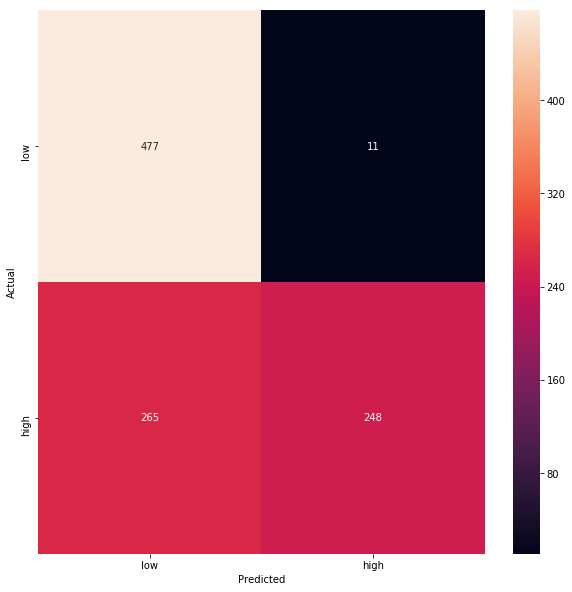

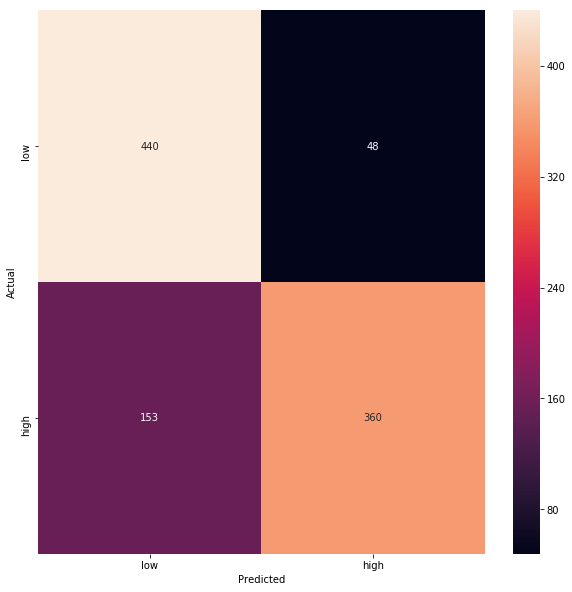

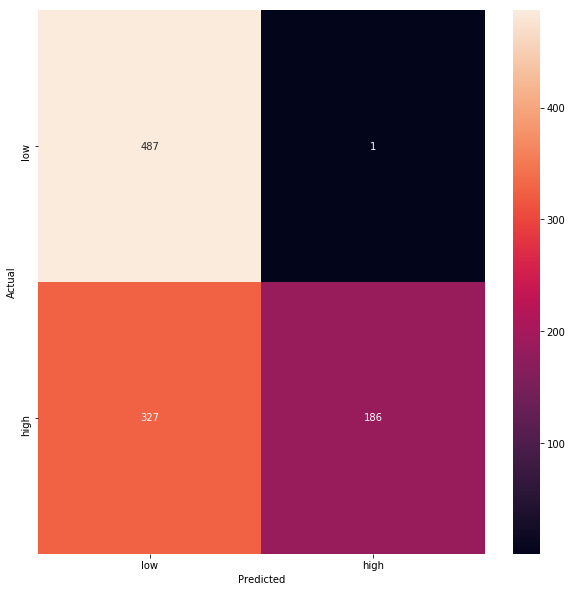

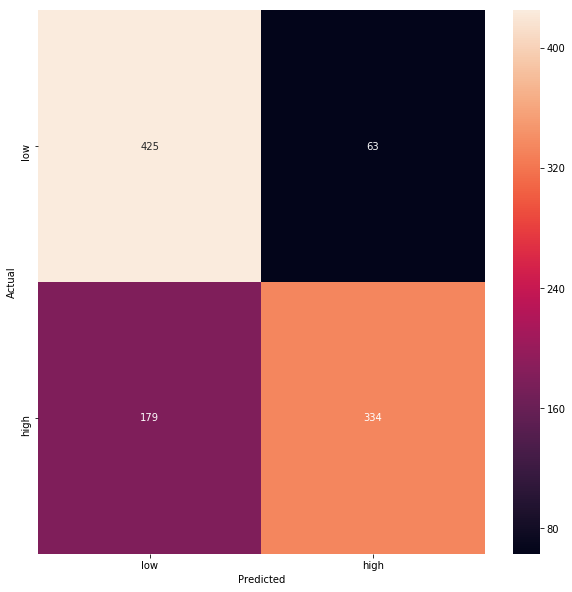

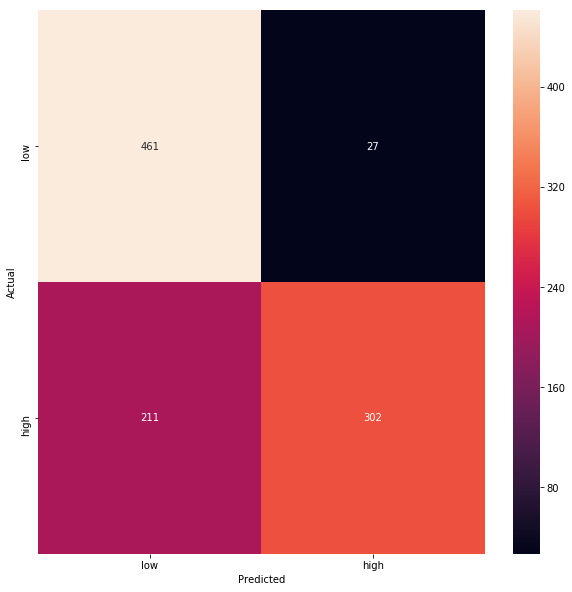

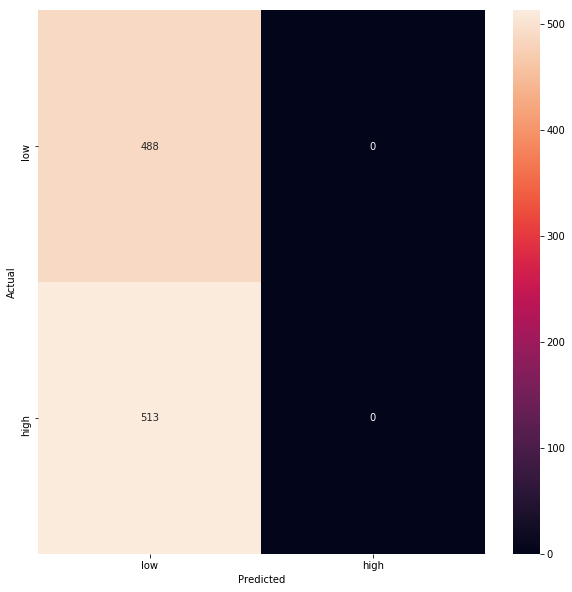

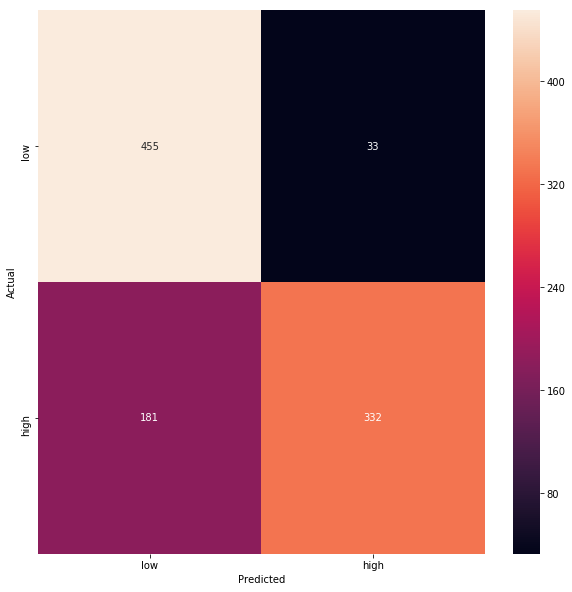

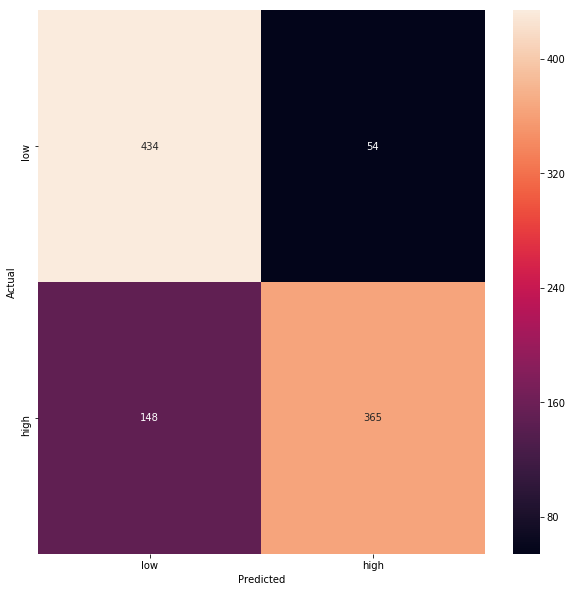

In [220]:
# model evaluation

for model in models:
    y_pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print("Recognition rate for " + str(model.__class__) + ": " + str(accuracy_score(y_test, y_pred)))

    conf_mat = confusion_matrix(y_test, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()